# Descripción

Clasificación binaria de **Masas**:
- El tamaño de las imágenes  es de 224x224
- Las etiquetas se generan aquí 
- NO se toman en cuenta las imágenes BWC

In [1]:
import pandas as pd
import numpy as np
import pydicom
import matplotlib.pyplot as plt

# Cargamos las  rutas de las imágenes:

MASAS:

In [2]:
rutas_train_mass_benign = np.load(r'E:\Pruebas Parches Resize con TF\RUTAS por etiquetas\rutas_train_mass_BENIGN_577.npy')

In [3]:
len(rutas_train_mass_benign)

577

In [4]:
rutas_test_mass_benign = np.load(r'E:\Pruebas Parches Resize con TF\RUTAS por etiquetas\rutas_test_mass_BENIGN_194.npy')

In [5]:
len(rutas_test_mass_benign)

194

In [6]:
rutas_train_mass_malignant = np.load(r'E:\Pruebas Parches Resize con TF\RUTAS por etiquetas\rutas_train_mass_MALIGNANT_637.npy')

In [7]:
len(rutas_train_mass_malignant)

637

In [8]:
rutas_test_mass_malignant = np.load(r'E:\Pruebas Parches Resize con TF\RUTAS por etiquetas\rutas_test_mass_MALIGNANT_147.npy')

In [9]:
len(rutas_test_mass_malignant)

147

In [10]:
577+147+637+194

1555

# Generamos las etiquetas (numericas) para ingresarlas al modelo

Masas: Malignant = 0, Benign = 1.

In [26]:
etiq_train_mass_malignant = np.zeros(len(rutas_train_mass_malignant), dtype=int)

In [27]:
len(etiq_train_mass_malignant)

637

In [28]:
etiq_test_mass_malignant = np.zeros(len(rutas_test_mass_malignant), dtype=int)

In [29]:
len(etiq_test_mass_malignant)

147

In [30]:
etiq_train_mass_benign = np.ones(len(rutas_train_mass_benign), dtype=int)

In [31]:
len(etiq_train_mass_benign)

577

In [32]:
etiq_test_mass_benign = np.ones(len(rutas_test_mass_benign), dtype=int)

In [33]:
len(etiq_test_mass_benign)

194

In [34]:
577+637

1214

In [35]:
194+147

341

# Concatenamos las rutas de las imagenes y etiquetas

In [44]:
rutas_train_mass = np.concatenate((rutas_train_mass_benign,rutas_train_mass_malignant)) #B luego M (1...,0...)

In [45]:
len(rutas_train_mass)

1214

In [46]:
etiq_train_mass = np.concatenate((etiq_train_mass_benign,etiq_train_mass_malignant)) ##B luego M (1...,0...)

In [47]:
len(etiq_train_mass)

1214

In [48]:
rutas_test_mass = np.concatenate((rutas_test_mass_benign,rutas_test_mass_malignant)) #B luego M (1...,0...)

In [49]:
len(rutas_test_mass)

341

In [50]:
etiq_test_mass = np.concatenate((etiq_test_mass_benign, etiq_test_mass_malignant)) #B luego M (1...,0...)

In [51]:
len(etiq_test_mass)

341

# Creamos los conjuntos Train, Validación
Usamos  **train_test_split** de sklearn para su reproducibilidad.

In [61]:
X = rutas_train_mass
y = etiq_train_mass

In [62]:
len(X)

1214

In [63]:
len(y)

1214

In [64]:
from sklearn.model_selection import train_test_split

In [65]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42) # stratify=y=labels

In [66]:
len(X_train)

1031

In [67]:
len(X_val)

183

# Funciones de TensorFlow

Para realizar operaciones de lectura y resize

In [82]:
import tensorflow as tf
from tensorflow.keras.utils import img_to_array # inst PIL --> ARREGLO NUMPY
from tensorflow.image import resize

Funcion resize con tf:

In [83]:
def resize_dicom(img_dicom,width,height): # Img DICOM readed ---> Tensor([width,heigth,1]), dtype float32 (originalmente son uint 16)
    pxls_img_dicom = img_dicom.pixel_array #Obtenemos los pixeles de las imágenes DICOM
    pxls_img_dicom_3D = img_to_array(pxls_img_dicom) #Formamos un tensor de la forma (w_DICOM,h_DICOM,1), escala de grises
    img_dicom_resize = resize(pxls_img_dicom_3D,(width,height)) #Se puede plotear con: plt.imshow(img_resize, cmap=plt.cm.bone)
    return img_dicom_resize

# Visualizacion

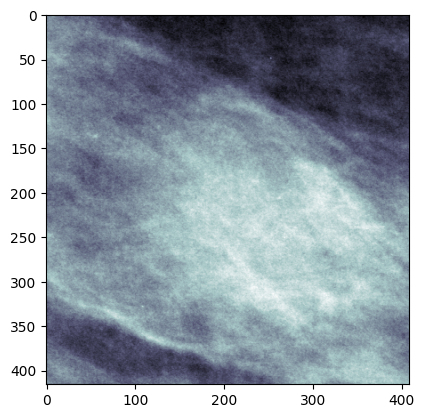

In [84]:
#Tamaño original
plt.imshow(pydicom.dcmread(X_train[100]).pixel_array, cmap=plt.cm.bone) # Img Original

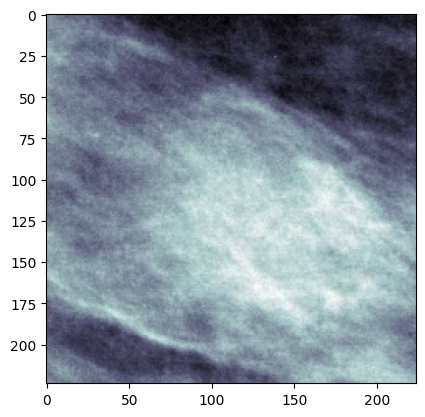

In [85]:
#imagen con resize
plt.imshow(resize_dicom(pydicom.dcmread(X_train[100]),224,224), cmap=plt.cm.bone) #Img con resize

# Obtencion de imagenes como tensores

In [86]:
#Funcion que les hace resize a las imagenes y obtiene los pixeles resultantes den forma de tensores
def genera_tensores_train_test(width,height,lista_de_rutas):
    """
    width a redimensionar
    height a redimensionar
    lista de rutas
    """
    imgs_tensores = []

    for file in list(lista_de_rutas):
        read_img_dicom = pydicom.dcmread(file) #Lectura imgs DICOM
        img_tensor = resize_dicom(read_img_dicom,width,height) #Lammado a la funcion resize_dicom ---> Tensor de "16 bits" con dtype = float32
        imgs_tensores.append(img_tensor) #juntar los tensores

    # Convertir listas a (arrays de NumPy) Tensores
    imagenes = tf.stack(imgs_tensores) #Axis = 0 por default, concatena en vertical(columnas), axis = 1 en horizontal (filas). --->(num_imgs,width,height,1)
    return imagenes # Tensores


## Obtencion de las imágenes como tensores

imgs_train, imgs_val e imgs_test

In [88]:
imgs_train = genera_tensores_train_test(224,224,X_train)

In [89]:
len(imgs_train)

1031

In [90]:
imgs_val = genera_tensores_train_test(224,224,X_val)

In [91]:
len(imgs_val)

183

In [92]:
imgs_test = genera_tensores_train_test(224,224,rutas_test_mass)

In [93]:
len(imgs_test)

341

# Preprocesamiento:

In [106]:
# Convertir del rango (0-65535) a (0-255), 2**8 =  (DATOS(2**16)/2**8) != (65535/65535)*255
train_images_mass = (imgs_train/65535)*255
val_images_mass = (imgs_val/65535)*255
test_images_mass = (imgs_test/65535)*255

In [107]:
#Replicate the only color channel (gray) 3 times, for Pre-trained Nets compatibility (se puede usar tf.TILE)
train_images_mass  = tf.image.grayscale_to_rgb(train_images_mass)
val_images_mass = tf.image.grayscale_to_rgb(val_images_mass)
test_images_mass = tf.image.grayscale_to_rgb(test_images_mass)

In [108]:
train_images_mass.shape

TensorShape([1031, 224, 224, 3])

In [109]:
val_images_mass.shape

TensorShape([183, 224, 224, 3])

In [110]:
test_images_mass

<tf.Tensor: shape=(341, 224, 224, 3), dtype=float32, numpy=
array([[[[198.54288 , 198.54288 , 198.54288 ],
         [202.72948 , 202.72948 , 202.72948 ],
         [201.89041 , 201.89041 , 201.89041 ],
         ...,
         [202.3872  , 202.3872  , 202.3872  ],
         [198.6291  , 198.6291  , 198.6291  ],
         [196.28775 , 196.28775 , 196.28775 ]],

        [[199.23979 , 199.23979 , 199.23979 ],
         [201.64929 , 201.64929 , 201.64929 ],
         [196.69    , 196.69    , 196.69    ],
         ...,
         [201.05974 , 201.05974 , 201.05974 ],
         [196.58028 , 196.58028 , 196.58028 ],
         [197.25252 , 197.25252 , 197.25252 ]],

        [[202.11418 , 202.11418 , 202.11418 ],
         [201.99046 , 201.99046 , 201.99046 ],
         [198.87268 , 198.87268 , 198.87268 ],
         ...,
         [197.1758  , 197.1758  , 197.1758  ],
         [196.82816 , 196.82816 , 196.82816 ],
         [197.71243 , 197.71243 , 197.71243 ]],

        ...,

        [[221.51677 , 221.51677 

# Experimentación

In [111]:
from keras import layers
from keras import models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
#from keras.applications import ResNet50, InceptionV3, DenseNet121, MobileNetV2, VGG19, VGG16
#from keras.applications.vgg19 import preprocess_input as  vgg_preprocess_input
#from tensorflow.keras.applications.resnet50 import preprocess_input as res_preprocess_input
#from keras.applications.inception_v3 import preprocess_input as inv3_preprocess_input
#from keras.applications.densenet import preprocess_input as dens_preprocess_input
#from keras.applications.mobilenet_v2 import preprocess_input as mob_preprocess_input

Importante al seleccionar la red y el preprocess_input

In [112]:
from keras.applications import InceptionV3
from keras.applications.inception_v3 import preprocess_input as inv3_preprocess_input

Semilla

In [113]:
#Establecer semilla global para las operaciones de Tensor Flow, numpy y python
seed_value = 42
tf.random.set_seed(seed_value)

# Inception V3

In [116]:
# Preprocess the test images
inv3_preprocess_input(test_images_mass)

<tf.Tensor: shape=(341, 224, 224, 3), dtype=float32, numpy=
array([[[[ 0.557199  ,  0.557199  ,  0.557199  ],
         [ 0.5900351 ,  0.5900351 ,  0.5900351 ],
         [ 0.58345425,  0.58345425,  0.58345425],
         ...,
         [ 0.5873506 ,  0.5873506 ,  0.5873506 ],
         [ 0.5578753 ,  0.5578753 ,  0.5578753 ],
         [ 0.5395118 ,  0.5395118 ,  0.5395118 ]],

        [[ 0.562665  ,  0.562665  ,  0.562665  ],
         [ 0.5815631 ,  0.5815631 ,  0.5815631 ],
         [ 0.5426667 ,  0.5426667 ,  0.5426667 ],
         ...,
         [ 0.5769391 ,  0.5769391 ,  0.5769391 ],
         [ 0.5418061 ,  0.5418061 ,  0.5418061 ],
         [ 0.5470786 ,  0.5470786 ,  0.5470786 ]],

        [[ 0.58520925,  0.58520925,  0.58520925],
         [ 0.5842389 ,  0.5842389 ,  0.5842389 ],
         [ 0.5597857 ,  0.5597857 ,  0.5597857 ],
         ...,
         [ 0.54647684,  0.54647684,  0.54647684],
         [ 0.5437503 ,  0.5437503 ,  0.5437503 ],
         [ 0.55068576,  0.55068576,  0.55068

In [117]:
test_preprocess = inv3_preprocess_input(test_images_mass)

Creación del MODELO

In [118]:
# Build a model using VGG16 convolutional base and new FC final layer
def create_inv3(fc_size, verbose=False, dropout=None): #fc_size=Número de neuronas finales
  inv3_base = InceptionV3(weights='imagenet', #Base convolucional CORRESPONDIENTE
                       include_top=False,
                       input_shape=(224,224, 3)) # Modifica según el tipo de entrada
  inv3 = models.Sequential()
  inv3.add(inv3_base)

  inv3.add(layers.Flatten())
  if dropout is not None:
    inv3.add(layers.Dropout(dropout, seed = seed_value)) # SEMILLA
  inv3.add(layers.Dense(fc_size, activation='relu'))#,kernel_initializer = inicializador))
  inv3.add(layers.Dense(1, activation='sigmoid'))#,kernel_initializer = inicializador)) # TIPO de PROBLEA: Binario o Multietiqueta

  # Freeze the convolutional base
  inv3_base.trainable = False

  if verbose:
    inv3_base.summary()
    inv3.summary()

  return inv3

In [119]:
Ejemplo = create_inv3(512, verbose=True)

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [120]:
# Create a HARD generator for training images (split = 0.15 it was 0.2)
train_datagen_HARD_inv3 = ImageDataGenerator(
    preprocessing_function = inv3_preprocess_input, #Preprocess indicado
    #validation_split=0.2, #!!! Separa en validación y entrenamiento !!!
    rotation_range=180,
    width_shift_range=0.2,#N
    height_shift_range=0.2, #N
    shear_range=15, #N Originalmente 10
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect',
)

# Fit the generator with some images
train_datagen_HARD_inv3.fit(train_images_mass)
val_datagen_inv3 = ImageDataGenerator(preprocessing_function = inv3_preprocess_input) #Preprocess_input adecuada

# Split train images into actual training and validation
train_generator_HARD_inv3 = train_datagen_HARD_inv3.flow(train_images_mass, y_train, batch_size=64, shuffle=False)#, subset='training')
validation_generator_inv3 = val_datagen_inv3.flow(val_images_mass, y_val, batch_size=64,shuffle=False)#, subset='validation')
#Se comenta subset ya que se ocupan distintos conjuntos de entrenamiento y validación, shuffle=True por default


In [129]:
# Instantiate network with custom final layer
fc_size = 128
inv3_fe_DO_H = create_inv3(fc_size = fc_size,dropout=0.5)

# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('inv3_fe_2cl_M-B_best'+f'_{fc_size}_DO_HARD.h5',#NOMBRE
        monitor='val_loss', mode='min', verbose=1,
        save_best_only=True, save_freq='epoch'
)

# Compile the model
inv3_fe_DO_H.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) # Cambiar el loss dependiendo del problema

In [130]:
# Train
history_inv3_fe_DO_H = inv3_fe_DO_H.fit_generator(
        train_generator_HARD_inv3, #Generador adecuado
        steps_per_epoch = len(X_train) // 64, #len(train_generator_HARD_vgg19), #n_train_img // 128, modificar 128 si se modifica el batch size
        epochs=300,
        validation_data=validation_generator_inv3,## GENRADOR CORRESP
        validation_steps=len(X_val)//64, #Parametro a usar dependiendo si se dispone de validation data
        callbacks= [checkpoint, earlystopping],
        shuffle=False,
        verbose=1,
        initial_epoch=0
)

# Save

models.save_model(inv3_fe_DO_H, 'inv3_fe_2cl_M-B_end'+f'_{fc_size}_DO_HARD.h5') #Modelo correspondiente


C:\Users\uabc_\AppData\Local\Temp\ipykernel_15404\1365260212.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_inv3_fe_DO_H = inv3_fe_DO_H.fit_generator(


Epoch 1/300
16/16 [==============================] - ETA: 0s - loss: 4.9573 - accuracy: 0.5059
Epoch 1: val_loss improved from inf to 0.68407, saving model to inv3_fe_2cl_M-B_best_128.h5
16/16 [==============================] - 13s 756ms/step - loss: 4.9573 - accuracy: 0.5059 - val_loss: 0.6841 - val_accuracy: 0.6250
Epoch 2/300
16/16 [==============================] - ETA: 0s - loss: 0.6973 - accuracy: 0.5352
Epoch 2: val_loss did not improve from 0.68407
16/16 [==============================] - 4s 236ms/step - loss: 0.6973 - accuracy: 0.5352 - val_loss: 0.6930 - val_accuracy: 0.5234
Epoch 3/300
16/16 [==============================] - ETA: 0s - loss: 0.6928 - accuracy: 0.5234
Epoch 3: val_loss did not improve from 0.68407
16/16 [==============================] - 4s 251ms/step - loss: 0.6928 - accuracy: 0.5234 - val_loss: 0.6929 - val_accuracy: 0.5234
Epoch 4/300
16/16 [==============================] - ETA: 0s - loss: 0.6936 - accuracy: 0.5195
Epoch 4: val_loss did not improve from 0

In [ ]:
#History of accuracy and loss
tra_loss_fe = history_inv3_fe_DO_H.history['loss'] # RENOMBRAR SI ES OTRO H5
tra_acc_fe = history_inv3_fe_DO_H.history['accuracy'] #######
val_loss_fe = history_inv3_fe_DO_H.history['val_loss'] ########
val_acc_fe = history_inv3_fe_DO_H.history['val_accuracy'] #########

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set OBSEVRA QUE SE CAMBBIAN los nombres de las variables
opt_inv3_fe_DO_H = models.load_model('inv3_fe_2cl_M-B_best'+f'_{fc_size}_DO_HARD.h5') #####Carga el modelo
test_loss_fe, test_acc_fe = inv3_fe_DO_H.evaluate(test_images_mass, etiq_test_mass, verbose=False) #######Evalua modelo
opt_test_loss_fe, opt_test_acc_fe = opt_inv3_fe_DO_H.evaluate(test_images_mass, etiq_test_mass, verbose=False) ##

print(f"InceptionV3 Feature Extraction W/ dropout Hard DA {fc_size}\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

#OBSERVACIÓN: Se debe evaluar en test_preprocess y no en test_images_mass :
#test_loss_fe, test_acc_fe = inv3_fe_DO_H.evaluate(test_preprocess, etiq_test_mass, verbose=False) #######Evalua modelo
#opt_test_loss_fe, opt_test_acc_fe = opt_inv3_fe_DO_H.evaluate(test_preprocess, etiq_test_mass, verbose=False) ##
#La evaluación correcta en el Test con el modelo óptimo se hizo abajo. Este error NO afecta el entrenamiento,
#ya que la función inv3_preprocess_input fue ingresada en el ImageDataGenerator 

InceptionV3 Feature Extraction W/ dropout Hard DA 128

Epoch [end]: 92
Epoch [opt]: 62
Valid accuracy [end]: 0.7031
Valid accuracy [opt]: 0.7109
Test accuracy [end]:  0.5220
Test accuracy [opt]:  0.5308
Valid loss [end]: 0.6291
Valid loss [opt]: 0.5983
Test loss [end]:  8.8244
Test loss [opt]:  7.2350


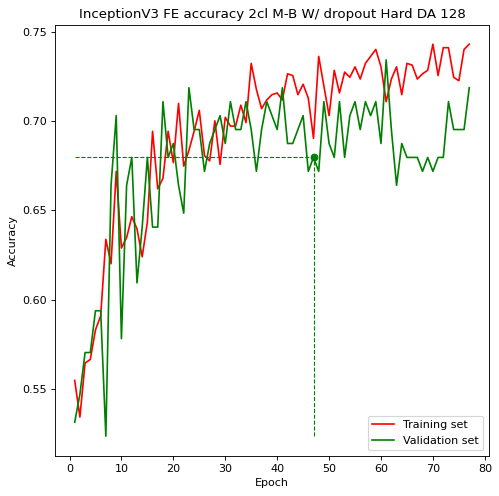

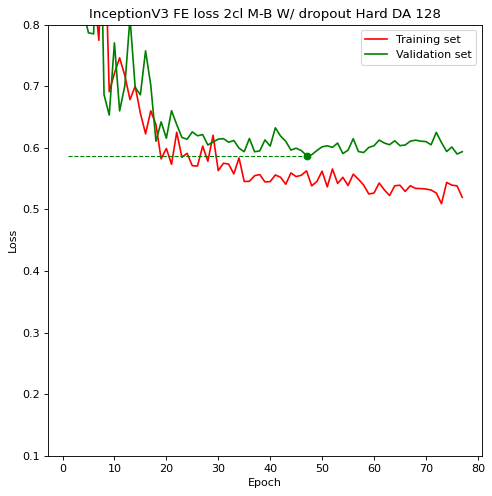

In [126]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title(f'InceptionV3 FE accuracy 2cl M-B W/ dropout Hard DA {fc_size}')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title(f'InceptionV3 FE loss 2cl M-B W/ dropout Hard DA {fc_size}')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0.1,0.8)
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [120]:
mod_64= models.load_model(r'inv3_fe_2cl_M-B_best_64_DO_HARD.h5') 
mod_64.evaluate(test_preprocess, etiq_test_mass) #7390 

11/11 [==============================] - 4s 28ms/step - loss: 0.6122 - accuracy: 0.7390


[0.6121728420257568, 0.7390029430389404]

In [120]:
mod_64_end= models.load_model(r'inv3_fe_2cl_M-B_end_64_DO_HARD.h5') 
mod_64_end.evaluate(test_preprocess, etiq_test_mass) #

11/11 [==============================] - 4s 28ms/step - loss: 0.6325 - accuracy: 0.7038


[0.6325343251228333, 0.703812301158905]

InceptionV3 Feature Extraction W/ dropout Hard DA 64

- Epoch [end]: 139
- Epoch [opt]: 109
- Valid accuracy [end]: 0.7109
- Valid accuracy [opt]: 0.6953
- Test accuracy [end]:  0.4311
- Test accuracy [opt]:  0.4311
- Valid loss [end]: 0.6224
- Valid loss [opt]: 0.5911
- Test loss [end]:  127.9436
- Test loss [opt]:  95.2366

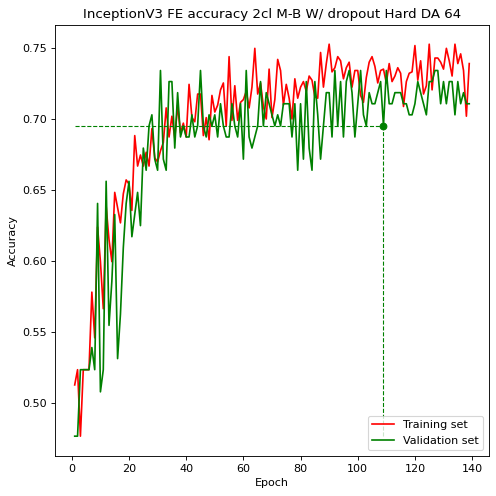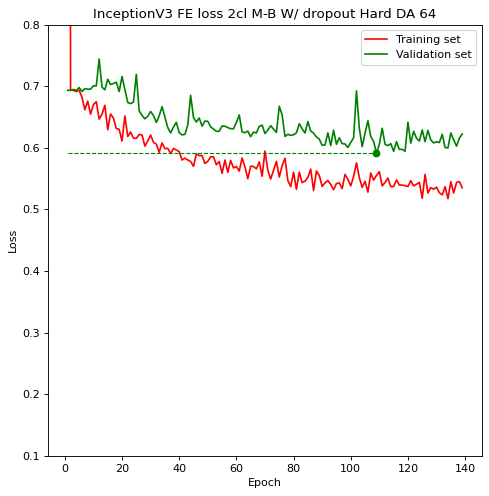

In [121]:
mod_256= models.load_model(r'inv3_fe_2cl_M-B_best_256_DO_HARD.h5')
mod_256.evaluate(test_preprocess, etiq_test_mass) #6891

11/11 [==============================] - 1s 23ms/step - loss: 0.6074 - accuracy: 0.6891


[0.6074086427688599, 0.6891495585441589]

InceptionV3 Feature Extraction W/ dropout Hard DA 256

- Epoch [end]: 80
- Epoch [opt]: 50
- Valid accuracy [end]: 0.6875
- Valid accuracy [opt]: 0.6875
- Test accuracy [end]:  0.4311
- Test accuracy [opt]:  0.4311
- Valid loss [end]: 0.6153
- Valid loss [opt]: 0.6004
- Test loss [end]:  51.5514
- Test loss [opt]:  40.9115

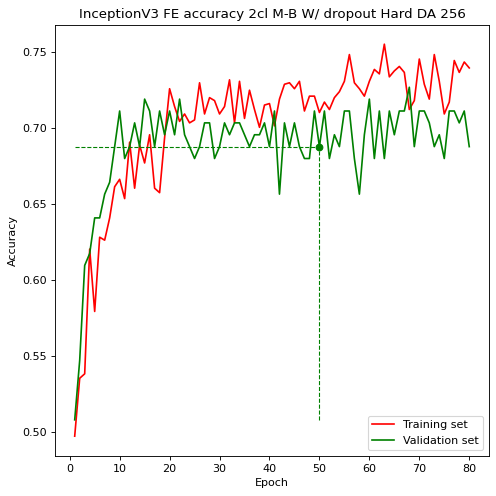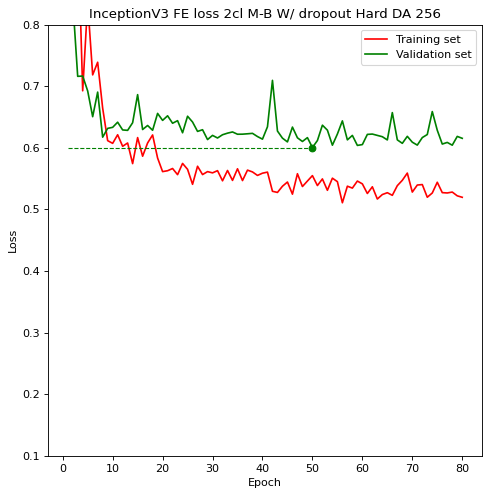

In [122]:
mod_128= models.load_model(r'inv3_fe_2cl_M-B_best_128_DO_HARD.h5')
mod_128.evaluate(test_preprocess, etiq_test_mass) #6686

11/11 [==============================] - 1s 33ms/step - loss: 0.5937 - accuracy: 0.6686


[0.5937231779098511, 0.6686217188835144]

InceptionV3 Feature Extraction W/ dropout Hard DA 128

- Epoch [end]: 200
- Epoch [opt]: 176
- Valid accuracy [end]: 0.6875
- Valid accuracy [opt]: 0.7031
- Test accuracy [end]:  0.5689
- Test accuracy [opt]:  0.5689
- Valid loss [end]: 0.6005
- Valid loss [opt]: 0.5807
- Test loss [end]:  25.3058
- Test loss [opt]:  25.2475

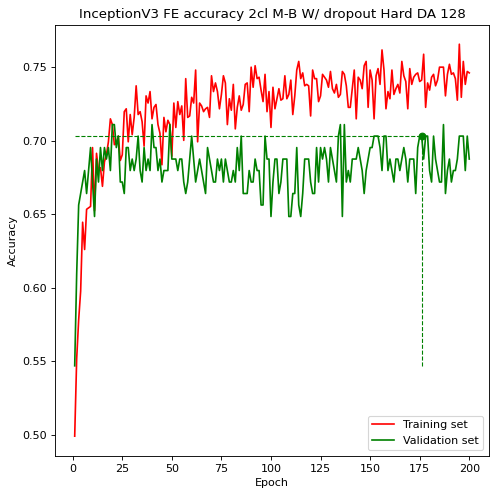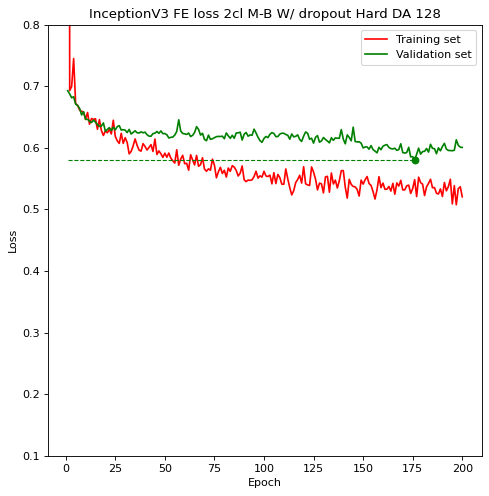

In [123]:
mod_512= models.load_model(r'inv3_fe_2cl_M-B_best_512_DO_HARD.h5')
mod_512.evaluate(test_preprocess, etiq_test_mass) #6744

11/11 [==============================] - 1s 33ms/step - loss: 0.6230 - accuracy: 0.6745


[0.6230143904685974, 0.6744868159294128]

InceptionV3 Feature Extraction W/ dropout Hard DA 512

- Epoch [end]: 83
- Epoch [opt]: 53
- Valid accuracy [end]: 0.6953
- Valid accuracy [opt]: 0.7109
- Test accuracy [end]:  0.4311
- Test accuracy [opt]:  0.4311
- Valid loss [end]: 0.6127
- Valid loss [opt]: 0.5873
- Test loss [end]:  59.5924
- Test loss [opt]:  26.1612

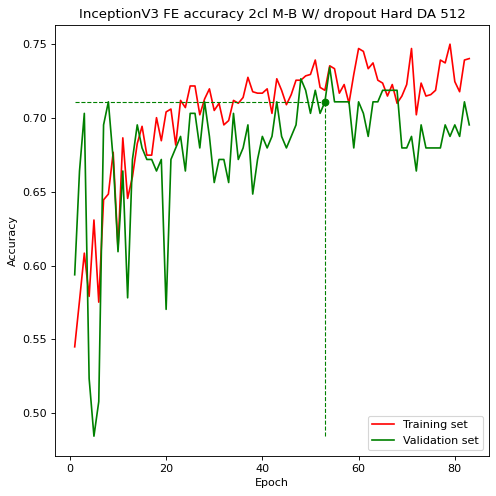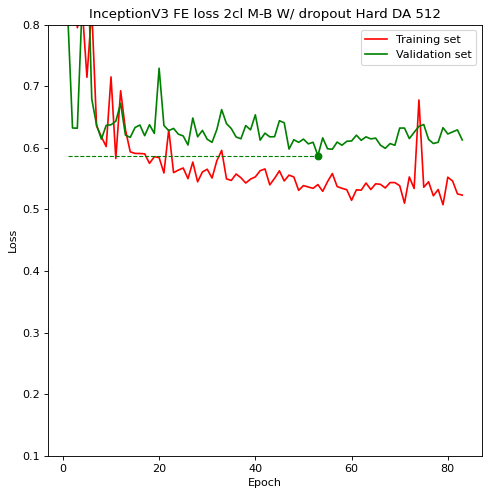

In [124]:
mod_1024= models.load_model(r'inv3_fe_2cl_M-B_best_1024_DO_HARD.h5')
mod_1024.evaluate(test_preprocess, etiq_test_mass) #7302

11/11 [==============================] - 1s 35ms/step - loss: 0.5764 - accuracy: 0.7302


[0.5763975381851196, 0.7302052974700928]

InceptionV3 Feature Extraction W/ dropout Hard DA 1024

- Epoch [end]: 77
- Epoch [opt]: 47
- Valid accuracy [end]: 0.7031
- Valid accuracy [opt]: 0.7188
- Test accuracy [end]:  0.4311
- Test accuracy [opt]:  0.4311
- Valid loss [end]: 0.6228
- Valid loss [opt]: 0.6040
- Test loss [end]:  70.8341
- Test loss [opt]:  20.0958

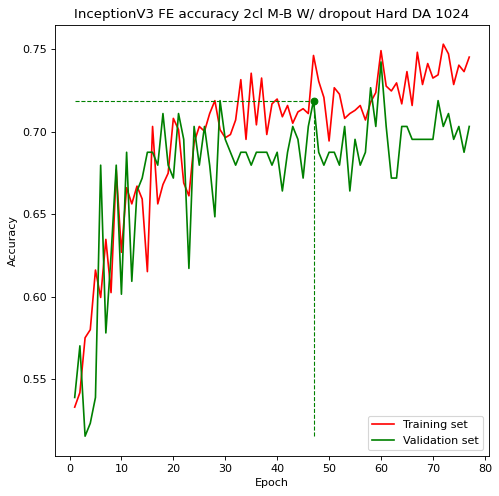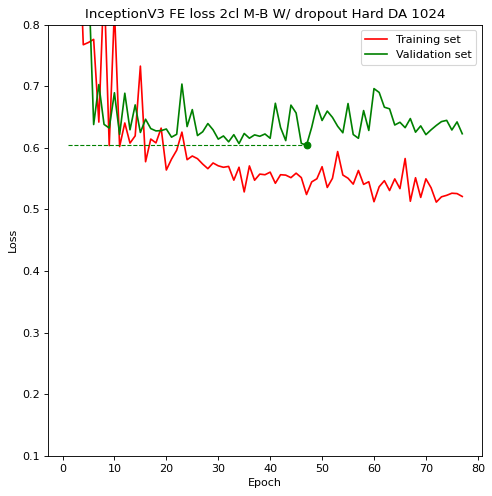

In [127]:
del inv3_fe_DO_H

In [128]:
del history_inv3_fe_DO_H

# Fine Tuning 1 Layer

## 1 Layer



In [121]:
from tensorflow.keras.optimizers import RMSprop

In [122]:
inv3_FT_1layer = models.load_model('inv3_fe_2cl_M-B_best_64_DO_HARD.h5') # OJO con respecto a que modelo

fine_tuned_from_1layer = 280

#Fine Tuning: unfreeze the last convolutional layer
for layer in inv3_FT_1layer.layers[0].layers[:fine_tuned_from_1layer]:
    layer.trainable = False

for layer in inv3_FT_1layer.layers[0].layers[fine_tuned_from_1layer:]:
    layer.trainable = True

# Recompile the model
inv3_FT_1layer.compile(optimizer = RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy',metrics=['accuracy'])

inv3_FT_1layer.summary()
inv3_FT_1layer.get_layer('inception_v3').summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_6 (Flatten)         (None, 51200)             0         
                                                                 
 dropout_5 (Dropout)         (None, 51200)             0         
                                                                 
 dense_12 (Dense)            (None, 64)                3276864   
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 25,079,713
Trainable params: 9,350,465
Non-trainable params: 15,729,248
_________________________________________________________________
Model: "inception_v3"
____________

In [123]:
# Early stopping (stop training after the validation loss reaches the minimum)

early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1) # cambia de nombre

# Callback for checkpointing
checkpoint = ModelCheckpoint('inv3_FT_1layer_2cl_M-B_best_64_DO_HARD.h5', #Nuevo nombre corresp al modelo cargado
        monitor='val_loss', mode='min', verbose=1,
        save_best_only=True, save_freq='epoch'
)


In [124]:
# Train
history_FT_1L = inv3_FT_1layer.fit_generator(
        train_generator_HARD_inv3, #Generador adecuado
        steps_per_epoch = len(X_train)//64, #len(train_generator_HARD_vgg16), #n_train_img // 128 y GENERADOR CORRESP
        epochs=200,
        validation_data=validation_generator_inv3,## GENRADOR CORRESP
        validation_steps = len(X_val)//64,
        callbacks= [checkpoint, early_stop], #Cambia eary stopping arriba
        shuffle=False,
        verbose=1,
        initial_epoch=0
)

# Save
models.save_model(inv3_FT_1layer, 'inv3_FT_1layer_2cl_M-B_end_64_DO_HARD.h5') #Modelo correspondiente


C:\Users\uabc_\AppData\Local\Temp\ipykernel_17520\1069317617.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_FT_1L = inv3_FT_1layer.fit_generator(


Epoch 1/200
16/16 [==============================] - ETA: 0s - loss: 0.6624 - accuracy: 0.6924
Epoch 1: val_loss improved from inf to 0.63635, saving model to inv3_FT_1layer_2cl_M-B_best_64_DO_HARD.h5
16/16 [==============================] - 11s 394ms/step - loss: 0.6624 - accuracy: 0.6924 - val_loss: 0.6364 - val_accuracy: 0.6953
Epoch 2/200
16/16 [==============================] - ETA: 0s - loss: 0.5819 - accuracy: 0.7080
Epoch 2: val_loss improved from 0.63635 to 0.62351, saving model to inv3_FT_1layer_2cl_M-B_best_64_DO_HARD.h5
16/16 [==============================] - 9s 575ms/step - loss: 0.5819 - accuracy: 0.7080 - val_loss: 0.6235 - val_accuracy: 0.6562
Epoch 3/200
16/16 [==============================] - ETA: 0s - loss: 0.5412 - accuracy: 0.7412
Epoch 3: val_loss did not improve from 0.62351
16/16 [==============================] - 4s 245ms/step - loss: 0.5412 - accuracy: 0.7412 - val_loss: 0.6805 - val_accuracy: 0.6719
Epoch 4/200
16/16 [==============================] - ETA: 

In [125]:
#History of accuracy and loss
tra_loss_fe = history_FT_1L.history['loss'] # RENOMBRAR SI ES OTRO H5
tra_acc_fe = history_FT_1L.history['accuracy'] #######
val_loss_fe = history_FT_1L.history['val_loss'] ########
val_acc_fe = history_FT_1L.history['val_accuracy'] #########

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set OBSEVRA QUE SE CAMBBIAN los nombres de las variables
opt_inv3_FT = models.load_model('inv3_FT_1layer_2cl_M-B_best_64_DO_HARD.h5') #####Carga el modelo
test_loss_fe, test_acc_fe = inv3_FT_1layer.evaluate(test_preprocess, etiq_test_mass, verbose=False) #######Evalua modelo
opt_test_loss_fe, opt_test_acc_fe = opt_inv3_FT.evaluate(test_preprocess, etiq_test_mass, verbose=False) ##

print("InceptionV3 FT 1 Layer (W/ dropout Hard DA) 64 U\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

InceptionV3 FT 1 Layer (W/ dropout Hard DA) 64 U

Epoch [end]: 40
Epoch [opt]: 10
Valid accuracy [end]: 0.6641
Valid accuracy [opt]: 0.7344
Test accuracy [end]:  0.6686
Test accuracy [opt]:  0.6891
Valid loss [end]: 0.8152
Valid loss [opt]: 0.6230
Test loss [end]:  0.8260
Test loss [opt]:  0.6741


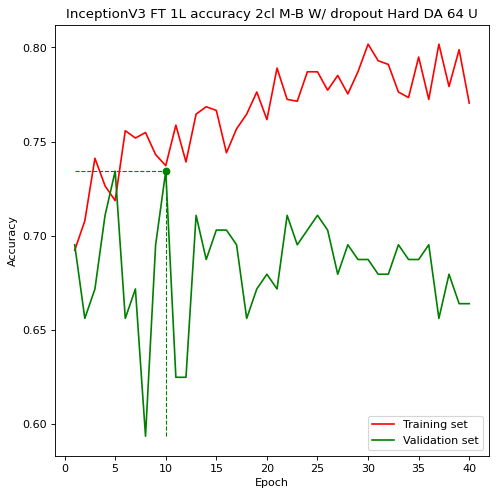

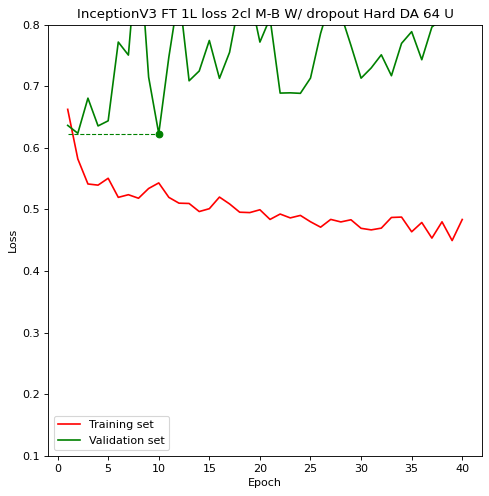

In [127]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('InceptionV3 FT 1L accuracy 2cl M-B W/ dropout Hard DA 64 U')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('InceptionV3 FT 1L loss 2cl M-B W/ dropout Hard DA 64 U')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0.1,0.8)
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

InceptionV3 FT 1 Layer (W/ dropout Hard DA) 64 U

- Epoch [end]: 40
- Epoch [opt]: 10
- Valid accuracy [end]: 0.6641
- Valid accuracy [opt]: 0.7344
- Test accuracy [end]:  0.6686
- Test accuracy [opt]:  0.6891
- Valid loss [end]: 0.8152
- Valid loss [opt]: 0.6230
- Test loss [end]:  0.8260
- Test loss [opt]:  0.6741

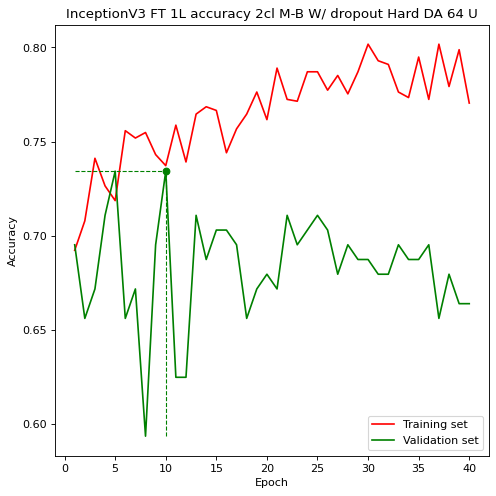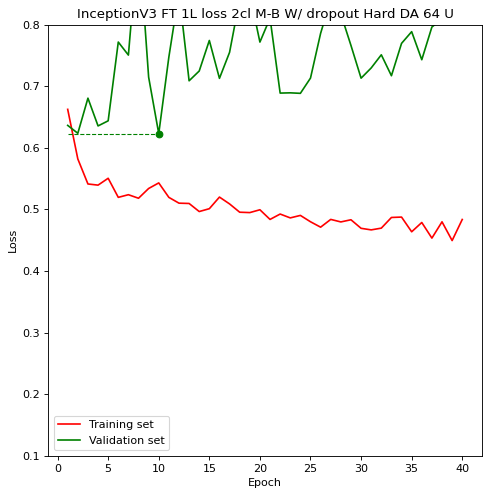

InceptionV3 FT 1 Layer (W/ dropout Hard DA) 128 U

- Epoch [end]: 40
- Epoch [opt]: 10
- Valid accuracy [end]: 0.6641
- Valid accuracy [opt]: 0.7188
- Test accuracy [end]:  0.4340
- Test accuracy [opt]:  0.5630
- Valid loss [end]: 0.7232
- Valid loss [opt]: 0.5964
- Test loss [end]:  1.0123
- Test loss [opt]:  11.9838

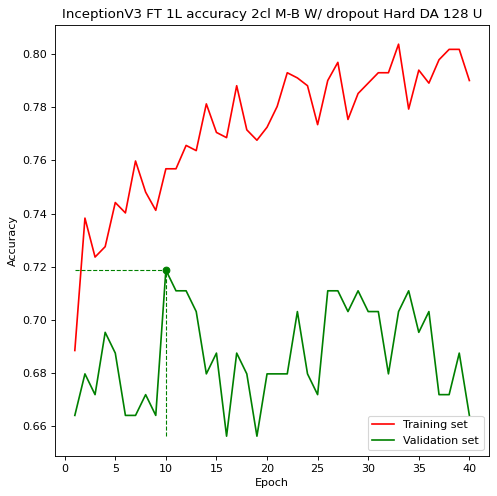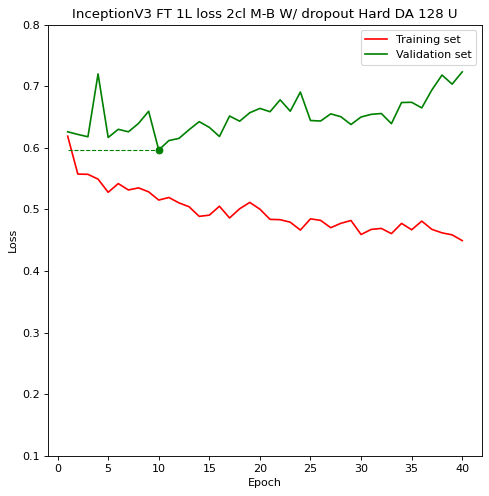

In [187]:
del inv3_FT_1layer
del history_FT_1L

# Fine Tuning 2 layers 

In [128]:
inv3_FT_2layer = models.load_model('inv3_FT_1layer_2cl_M-B_best_64_DO_HARD.h5') # OJO con respecto a que modelo

fine_tuned_from_2layer = 249

#Fine Tuning: unfreeze the last convolutional layer
for layer in inv3_FT_2layer.layers[0].layers[:fine_tuned_from_2layer]:
    layer.trainable = False

for layer in inv3_FT_2layer.layers[0].layers[fine_tuned_from_2layer:]:
    layer.trainable = True

# Recompile the model
inv3_FT_2layer.compile(optimizer = RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy',metrics=['accuracy'])

inv3_FT_1layer.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_6 (Flatten)         (None, 51200)             0         
                                                                 
 dropout_5 (Dropout)         (None, 51200)             0         
                                                                 
 dense_12 (Dense)            (None, 64)                3276864   
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 25,079,713
Trainable params: 9,350,465
Non-trainable params: 15,729,248
_________________________________________________________________


In [129]:
# Early stopping (stop training after the validation loss reaches the minimum)

early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1) # cambia de nombre

# Callback for checkpointing
checkpoint = ModelCheckpoint('inv3_FT_2layer_2cl_M-B_best_64_DO_HARD.h5', #Nuevo nombre corresp al modelo cargado
        monitor='val_loss', mode='min', verbose=1,
        save_best_only=True, save_freq='epoch'
)


In [130]:
# Train
history_FT_2L = inv3_FT_2layer.fit_generator(
        train_generator_HARD_inv3, #Generador adecuado
        steps_per_epoch = len(X_train)//64, #len(train_generator_HARD_vgg16), #n_train_img // 128 y GENERADOR CORRESP
        epochs=200,
        validation_data=validation_generator_inv3,## GENRADOR CORRESP
        validation_steps = len(X_val)//64,
        callbacks= [checkpoint, early_stop], #Cambia eary stopping arriba
        shuffle=False,
        verbose=1,
        initial_epoch=0
)

# Save
models.save_model(inv3_FT_2layer, 'inv3_FT_2layer_2cl_M-B_end_64_DO_HARD.h5') #Modelo correspondiente


C:\Users\uabc_\AppData\Local\Temp\ipykernel_17520\580229324.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_FT_2L = inv3_FT_2layer.fit_generator(


Epoch 1/200
16/16 [==============================] - ETA: 0s - loss: 0.6018 - accuracy: 0.6982
Epoch 1: val_loss improved from inf to 0.83658, saving model to inv3_FT_2layer_2cl_M-B_best_64_DO_HARD.h5
16/16 [==============================] - 10s 468ms/step - loss: 0.6018 - accuracy: 0.6982 - val_loss: 0.8366 - val_accuracy: 0.6797
Epoch 2/200
16/16 [==============================] - ETA: 0s - loss: 0.5360 - accuracy: 0.7549
Epoch 2: val_loss improved from 0.83658 to 0.82144, saving model to inv3_FT_2layer_2cl_M-B_best_64_DO_HARD.h5
16/16 [==============================] - 9s 601ms/step - loss: 0.5360 - accuracy: 0.7549 - val_loss: 0.8214 - val_accuracy: 0.6719
Epoch 3/200
16/16 [==============================] - ETA: 0s - loss: 0.5350 - accuracy: 0.7285
Epoch 3: val_loss improved from 0.82144 to 0.79280, saving model to inv3_FT_2layer_2cl_M-B_best_64_DO_HARD.h5
16/16 [==============================] - 9s 549ms/step - loss: 0.5350 - accuracy: 0.7285 - val_loss: 0.7928 - val_accuracy: 0.

In [131]:
#History of accuracy and loss
tra_loss_fe = history_FT_2L.history['loss'] # RENOMBRAR SI ES OTRO H5
tra_acc_fe = history_FT_2L.history['accuracy'] #######
val_loss_fe = history_FT_2L.history['val_loss'] ########
val_acc_fe = history_FT_2L.history['val_accuracy'] #########

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set OBSEVRA QUE SE CAMBBIAN los nombres de las variables
opt_inv3_FT = models.load_model('inv3_FT_2layer_2cl_M-B_best_64_DO_HARD.h5') #####Carga el modelo
test_loss_fe, test_acc_fe = inv3_FT_2layer.evaluate(test_preprocess, etiq_test_mass, verbose=False) #######Evalua modelo
opt_test_loss_fe, opt_test_acc_fe = opt_inv3_FT.evaluate(test_preprocess, etiq_test_mass, verbose=False) ##

print("InceptionV3 FT 2 Layer (W/ dropout Hard DA) 64 U\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

InceptionV3 FT 2 Layer (W/ dropout Hard DA) 64 U

Epoch [end]: 38
Epoch [opt]: 8
Valid accuracy [end]: 0.6484
Valid accuracy [opt]: 0.7188
Test accuracy [end]:  0.6364
Test accuracy [opt]:  0.6657
Valid loss [end]: 0.9607
Valid loss [opt]: 0.7021
Test loss [end]:  0.9729
Test loss [opt]:  0.7556


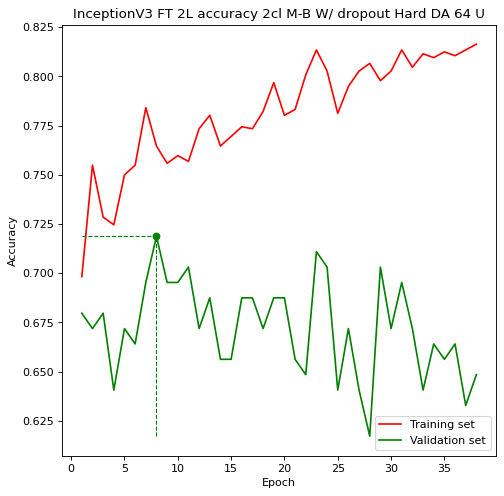

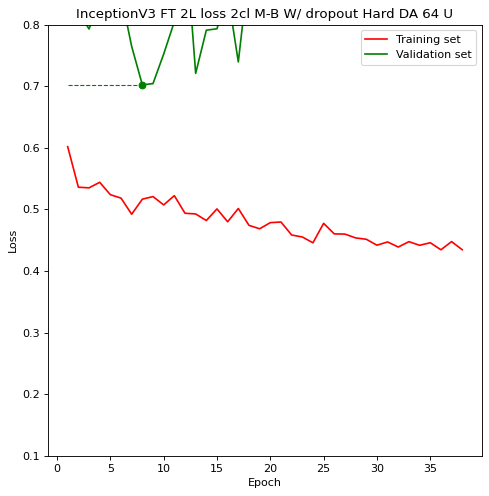

In [132]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('InceptionV3 FT 2L accuracy 2cl M-B W/ dropout Hard DA 64 U')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('InceptionV3 FT 2L loss 2cl M-B W/ dropout Hard DA 64 U')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0.1,0.8)
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [186]:
del inv3_FT_2layer
del history_FT_2L